In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from common import OUTPUTPATH, ignore_warning
from plotting import plot_model_partial_dependency, estimator_feature_importance
from models import gam_pcc
import data

ignore_warning()

In [2]:
# estimators here
gam_pcc.fit(data.x1, data.y)

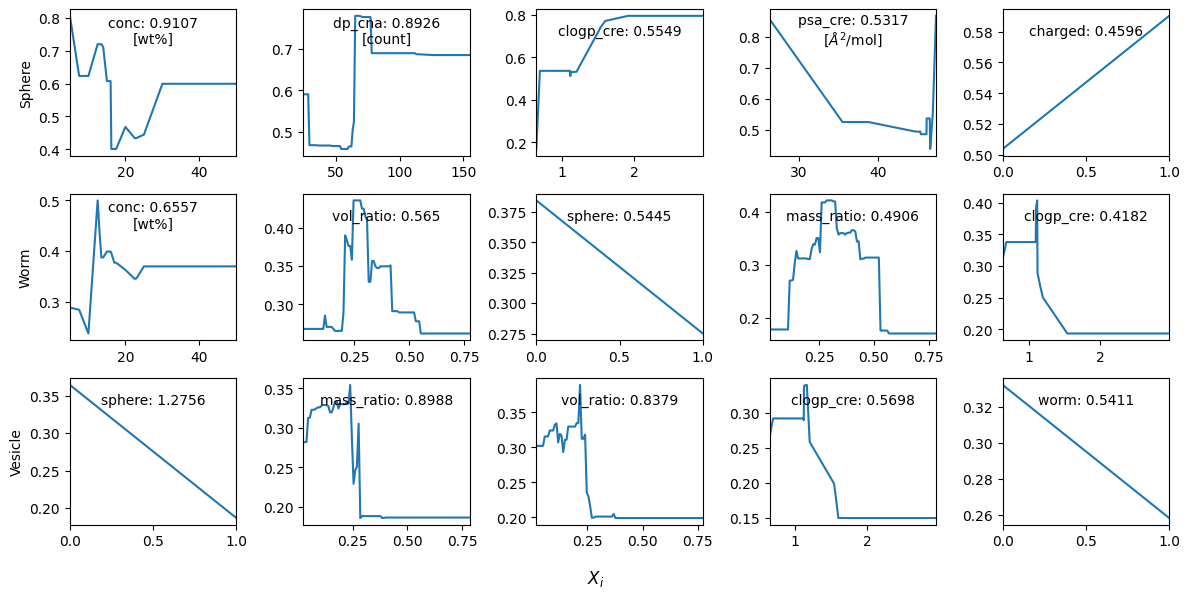

In [3]:
num_importance = 5
data1 = pd.concat([data.abbrev_x1, data.y], axis=1)

plot_model_partial_dependency(gam_pcc.fitted_, data1, num_importance, data.unit_comp, figsize=(12, 6),  sharey='none')
# plt.suptitle('GAM Top {} partial dependency with importance score'.format(num_importance))
plt.savefig(os.path.join(OUTPUTPATH, 'GAM_Top_5_partial_dependency.pdf'), bbox_inches='tight', pad_inches=0)

plt.show()

Assume we have a set of discretized variable $X=\{X_1', X_2', \dots ,X_p'\}$ and a binary target variable value $Y$. We build a tree $T_i$ to fit the pairwise data (i.e., $\{X_i', Y\}$). For a given tree $T_i$, we define that $\theta_j$ is the logodds of $L_j$ th leaf.    

Here, we take an example of $X_i'$ feature importance computation.    

Givrn a sample dataset $x=\{x_1,\dots, x_n\}$, the log odds for each point can be presented as:

$$
g(x_k) = \begin{cases}
    \theta_j, & \delta(x_k \in L_j) \\
    0,              & \text{otherwise}
    \end{cases}
$$

Hence, the empirical logodds can be defined as:
$$
\hat \theta_D =  \frac{1}{n}\sum_k^n g(x_k)
$$

Then, the author applied a formula below:
$$
f(x_k) = \begin{cases}
    |\theta_j - \hat \theta_D|, & \delta(x_k \in L_j) \\
    0,              & \text{otherwise}
    \end{cases}
$$

Hence, $X_i'$ feature importance can be defined as:

$$ \mathcal{I} =\frac{1}{n}\sum_{k=1}^n f(x_k)$$



In [4]:
# example of one pcc gam model
# get the logodds of each leaf
est = gam_pcc.fitted_[0]
feature_groups_ = est.feature_groups_ # [[0], [1], [2], ... [22]] all individual features
estimators = est.bagged_models_ # bagged models 8 models

additive_terms_ = []
for index, _ in enumerate(feature_groups_):
    log_odds_tensors = []
    for estimator in estimators:
        log_odds_tensors.append(estimator.model_[index])

    averaged_model = np.average(np.array(log_odds_tensors), axis=0) # contains discretized X log odds.
    additive_terms_.append(averaged_model) # average logodds performance of each feature (E(logodds))


In [5]:
averaged_model, est.preprocessor_.transform(data.x1.values).T[-1] # example of last variable model logloss and discretization

(array([ 2.08472568,  2.08472568,  2.08472568,  0.46832304, -0.64701161,
        -0.51215883,  0.05583073,  0.06191301]),
 array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5,
        7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [6]:
est.preprocessor_.transform(data.x1.values) # discretized each variable

array([[11,  5,  4, ...,  1,  1,  7],
       [11,  5,  4, ...,  1,  1,  7],
       [11,  5,  4, ...,  1,  1,  7],
       ...,
       [11,  5,  4, ...,  1,  1,  7],
       [11,  5,  4, ...,  1,  1,  7],
       [11,  5,  4, ...,  1,  1,  7]])

In [7]:
X = est.preprocessor_.transform(data.x1.values).T # reshape
scores_gen = []
for set_idx, feature_group in enumerate(feature_groups_):
    tensor = additive_terms_[set_idx] # get each variable corresponding model logloss performance

    # Get the current column(s) to process
    feature_idxs = feature_group
    sliced_X = X[feature_idxs, :] # 592 points with limited discretization index
    scores = tensor[tuple(sliced_X)]
    unknowns = (sliced_X < 0).any(axis=0)
    scores[unknowns] = 0 # each point has a logloss of its discretization

    # update the scores by weight deduction of the mean values
    score_mean = np.average(scores, weights=None) # same with np.mean
    tensor = (
        tensor - score_mean
    )
    # E(\theta_{logodds}) - E(logodds)

    # re-assign values to points
    scores = tensor[tuple(sliced_X)]
    unknowns = (sliced_X < 0).any(axis=0)
    scores[unknowns] = 0

    scores_gen.append([set_idx, feature_group, scores])

In [8]:
feature_importances_ = []
for set_idx, _, scores in scores_gen:
    mean_abs_score = np.mean(np.abs(scores)) # get mean values
    feature_importances_.append(mean_abs_score)

feature_importance_dic = dict(zip(data.abbrev_x1.columns, feature_importances_))
feature_importance_dic = {key: value for key, value in sorted(feature_importance_dic.items(), key=lambda item: item[1], reverse=True)}

In [9]:
est.feature_importances_ == feature_importances_ # proof our feature importance calculation

True

In [10]:
feature_importance_dic

{'conc': 0.9106768762148928,
 'dp_cna': 0.8925846472036959,
 'clogp_cre': 0.554942634413088,
 'psa_cre': 0.5316863722206339,
 'charged': 0.4595972284476562,
 'mv_tot_cre': 0.4269067430671307,
 'vol_ratio': 0.4040949761003135,
 'mv_tot_cna': 0.3796114103571172,
 'mw_tot_cre': 0.3785617623001777,
 'mw_cre': 0.37158756871272985,
 'mass_ratio': 0.365374941524453,
 'apol_cre': 0.31195846539092653,
 'dp_cre': 0.2947170056019321,
 'mv_cre': 0.28322278902313686,
 'mw_tot_cna': 0.2794171868531725,
 'apol_cna': 0.22958471866813587,
 'psa_cna': 0.22941463561688735,
 'mw_cna': 0.22223215165321605,
 'mv_cna': 0.2146418518100103,
 'ph': 0.1966331008192628,
 'clogp_cna': 0.17202180982271958,
 'temp': 0.1545846686097651,
 'salt': 0.0670583436314005}